In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from itertools import product
from tqdm import tqdm

from device_definition import device_definition,  plotting_device_resonances, plotting_device_resonances_iter
from simplified_sequential_assignment import optimal_sequential_assignment, device_resonances_heated_func
from simplified_mrm_crr_cycling import mrm_cycling_func, crr_locking_func
from copy import deepcopy

## MRM and CRR resonance definition

In [2]:
tx_bank, rx_bank, laser = device_definition(no_iterations=20001, centroid_die_variation_bool=False, laser_distribution_uniform=False, die_variation_uniform_bool=False)

mrm_resonances_die_wafer_variation = tx_bank["mrm_resonances_die_wafer_variation"]
crr_resonances_die_wafer_variation = rx_bank["crr_resonances_die_wafer_variation"]
ideal_resonance = tx_bank["ideal_resonances"]
laser_frequency = laser["laser_frequency"]

step_sweep = 200

no_mrm_cycling_steps = 4
no_crr_cycling_steps = 6

no_mrm_internal_alignment_steps = 20
no_crr_internal_alignment_steps = 20

debug = 0

bins = 101

## Plotting MRM and CRR resonances

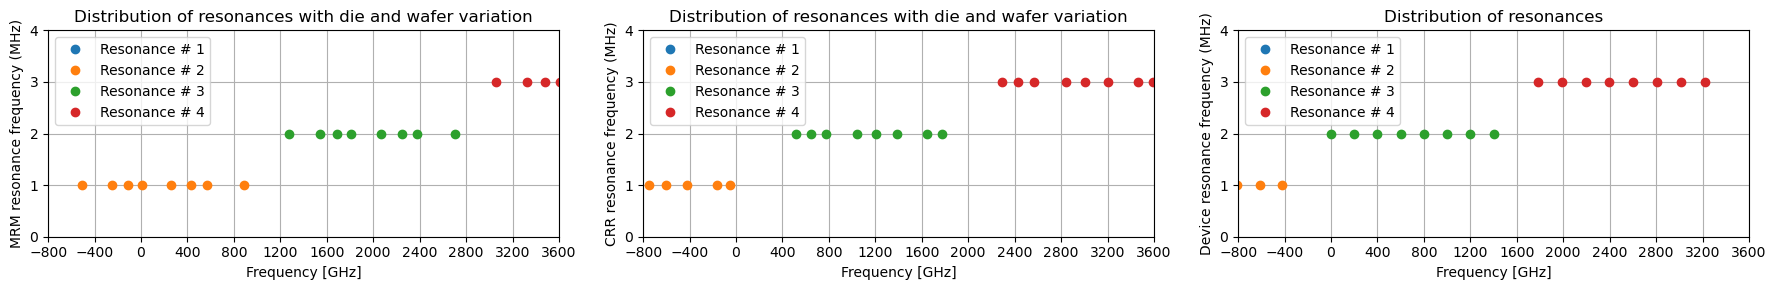

In [3]:
fig = plt.figure(figsize=(18,3))
plt.subplot(131)
plotting_device_resonances(mrm_resonances_die_wafer_variation)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("MRM resonance frequency (MHz)")
plt.subplot(132)
plotting_device_resonances(crr_resonances_die_wafer_variation)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("CRR resonance frequency (MHz)")
plt.subplot(133)
plotting_device_resonances(ideal_resonance)
plt.title("Distribution of resonances")
plt.ylabel("Device resonance frequency (MHz)")
plt.tight_layout()
plt.show()

## Sequential Assignment of MRM

In [4]:
mrm_lock_data = np.zeros((mrm_resonances_die_wafer_variation.shape[0], 7, mrm_resonances_die_wafer_variation.shape[2]))
mrm_sequential_success_metric = []
iter_satisfaction = []

mrm_laser_assigned = []
mrm_sequential_assigned = []

for iter_no in tqdm(range(mrm_resonances_die_wafer_variation.shape[2])):
  mrm_resonances_iter = mrm_resonances_die_wafer_variation[:, :, iter_no]
  if debug:
    print("\n")
    print("Iteration number", iter_no)
  device_dict = optimal_sequential_assignment(mrm_resonances_iter, laser_frequency, device_optical_bandwidth = tx_bank["mrm_optical_bandwidth"], step_sweep = 200, debug = debug, optimization_bool=True)
  heat_assigned = device_dict["heat_assigned"] + (device_dict["heat_cycling"] + device_dict["cool_cycling"]) * np.ones(mrm_resonances_iter.shape[0]) * step_sweep
  heat_applied = device_dict["heat_applied"] + (device_dict["heat_cycling"] + device_dict["cool_cycling"])  * np.ones(mrm_resonances_iter.shape[0]) * step_sweep
    
  optimized_heat = deepcopy(heat_assigned)
  mrm_lock_data[:, 0, iter_no] = device_dict["device_assigned"]
  mrm_lock_data[:, 1, iter_no] = device_dict["laser_assigned"]
  mrm_lock_data[:, 2, iter_no] = heat_assigned
  mrm_lock_data[:, 3, iter_no] = heat_applied
  mrm_lock_data[:, 4, iter_no] = device_dict["resonance_assigned"]
  mrm_lock_data[:, 5, iter_no] = device_dict["heat_cycling"]
  mrm_lock_data[:, 6, iter_no] = device_dict["cool_cycling"]
  
  if len(np.unique(device_dict["laser_assigned"])) == 8:
    mrm_sequential_success_metric.append(iter_no)

print("Successful sequential alignment of MRM to laser wavelengths", len(mrm_sequential_success_metric)/mrm_resonances_die_wafer_variation.shape[2]*100, "%")


100%|██████████| 20001/20001 [00:02<00:00, 7844.20it/s]

Successful sequential alignment of MRM to laser wavelengths 100.0 %


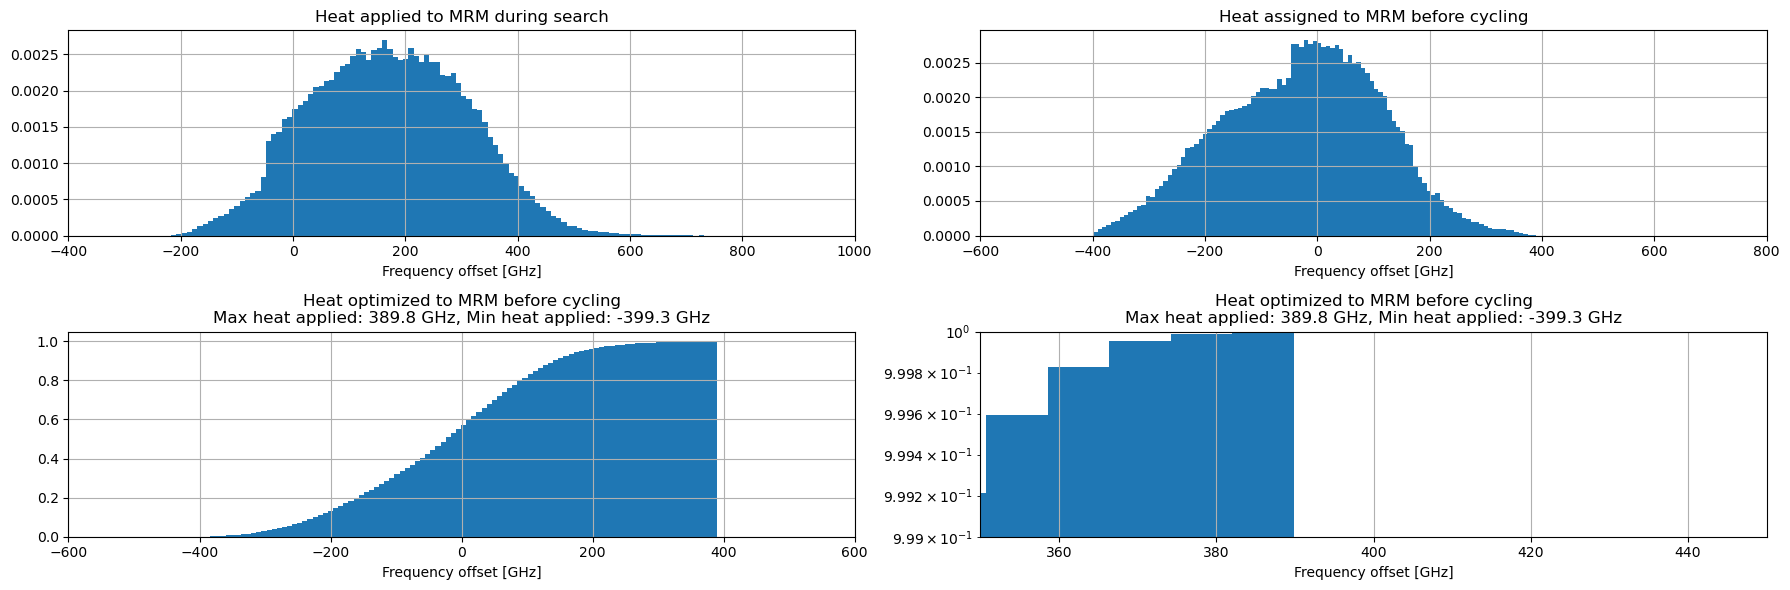

In [5]:
plt.figure(figsize=(18,6))
plt.subplot(221)
plt.hist(mrm_lock_data[:, 3, :].flatten(), density=True, bins=bins)
plt.xlim([-400, 1000])
plt.grid()
plt.title("Heat applied to MRM during search")
plt.xlabel("Frequency offset [GHz]")
plt.subplot(222)
plt.hist(mrm_lock_data[:, 2, :].flatten(), density=True,  bins=bins)
plt.xlim([-600, 800])
plt.title("Heat assigned to MRM before cycling")
plt.xlabel("Frequency offset [GHz]")
plt.grid()
plt.subplot(223)
plt.hist(mrm_lock_data[:, 2, :].flatten(), cumulative=True, density=True,  bins=bins)
plt.xlim([-600, 600])
plt.title("Heat optimized to MRM before cycling\n"+f"Max heat applied: {np.max(mrm_lock_data[:, 2, :]):0.1f} GHz, "+f"Min heat applied: {np.min(mrm_lock_data[:, 2, :]):0.1f} GHz")
plt.xlabel("Frequency offset [GHz]")
plt.grid()
plt.tight_layout()
plt.subplot(224)
plt.hist(mrm_lock_data[:, 2, :].flatten(), cumulative=True, density=True,  bins=bins)
plt.yscale("log")
plt.ylim(0.999, 1.0)
plt.xlim([350, 450])
plt.title("Heat optimized to MRM before cycling\n"+f"Max heat applied: {np.max(mrm_lock_data[:, 2, :]):0.1f} GHz, "+f"Min heat applied: {np.min(mrm_lock_data[:, 2, :]):0.1f} GHz")
plt.xlabel("Frequency offset [GHz]")
plt.grid()
plt.tight_layout()
plt.show()


In [6]:
for iter_no in range(mrm_resonances_die_wafer_variation.shape[2]):
    if np.min(mrm_lock_data[:, 2, iter_no]) < 000:
        print("Iteration number", iter_no)
        print("MRM sequence:", mrm_lock_data[:, 0, iter_no])
        print("Laser assigned:", mrm_lock_data[:, 1, iter_no])
        print("Heat assigned:", mrm_lock_data[:, 2, iter_no])
        print("Heat applied:", mrm_lock_data[:, 3, iter_no])
        print("Resonance assigned:", mrm_lock_data[:, 4, iter_no])
        print("Heat cycling:", mrm_lock_data[:, 5, iter_no])
        print("Cool cycling:", mrm_lock_data[:, 6, iter_no])
        break

Iteration number 0
MRM sequence: [7. 6. 5. 4. 3. 2. 1. 0.]
Laser assigned: [7. 2. 6. 1. 5. 0. 4. 3.]
Heat assigned: [ 91.89388813 235.09319045 156.1072575  137.91764859 193.34242326
 108.41466596  59.8415681  -74.46156645]
Heat applied: [ 91.89388813 419.09319045 366.1072575  333.91764859 391.34242326
 316.41466596 245.8415681  325.53843355]
Resonance assigned: [3. 2. 3. 2. 3. 2. 3. 3.]
Heat cycling: [0. 0. 0. 0. 0. 0. 0. 0.]
Cool cycling: [0. 0. 0. 0. 0. 0. 0. 0.]


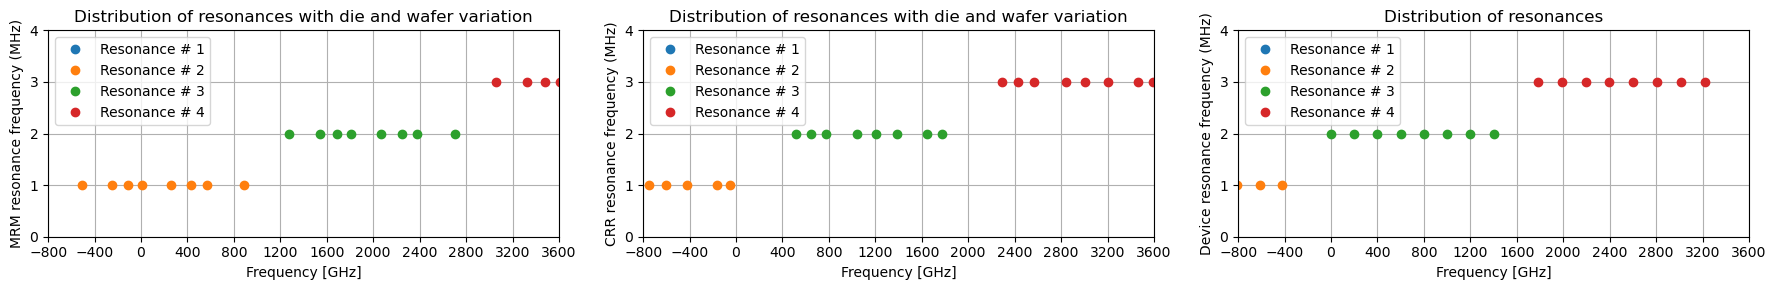

In [7]:
fig = plt.figure(figsize=(18,3))
plt.subplot(131)
plotting_device_resonances(mrm_resonances_die_wafer_variation, idd_iter = iter_no)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("MRM resonance frequency (MHz)")
plt.subplot(132)
plotting_device_resonances(crr_resonances_die_wafer_variation, idd_iter = iter_no)
plt.title("Distribution of resonances with die and wafer variation")
plt.ylabel("CRR resonance frequency (MHz)")
plt.subplot(133)
plotting_device_resonances(ideal_resonance, idd_iter = iter_no)
plt.title("Distribution of resonances")
plt.ylabel("Device resonance frequency (MHz)")
plt.tight_layout()
plt.show()

## Barrel-roll cycling of MRMs

In [8]:
no_mrm_cycling_steps = 4
cycled_mrm_lock_data = np.zeros((mrm_resonances_die_wafer_variation.shape[0], 7*no_mrm_cycling_steps, mrm_resonances_die_wafer_variation.shape[2]))
iter_no = 0


cycled_mrm_sequential_success_metric = []
for iter_no in tqdm(range(mrm_resonances_die_wafer_variation.shape[2])):
    for mrm_cycling_no in range(no_mrm_cycling_steps):
        mrm_heat_cycling = mrm_lock_data[0, 5, iter_no]
        total_mrm_heat_cycling = mrm_cycling_no + mrm_heat_cycling
        mrm_heat_assigned = mrm_lock_data[:, 2, iter_no]

        cycled_mrm_dict = mrm_cycling_func(mrm_resonances_iter, laser_frequency, tx_bank["mrm_optical_bandwidth"], mrm_heat_assigned, total_mrm_heat_cycling, step_sweep = step_sweep, debug = 0)
        
        if len(np.unique(cycled_mrm_dict["cycled_mrm_laser_assigned"])) == 8:
            cycled_mrm_sequential_success_metric.append(iter_no)
            break

print("Successful sequential alignment of MRM to laser wavelengths", len(cycled_mrm_sequential_success_metric*no_mrm_cycling_steps)/mrm_resonances_die_wafer_variation.shape[2]/no_mrm_cycling_steps*100, "%")


100%|██████████| 20001/20001 [00:03<00:00, 6356.23it/s]

Successful sequential alignment of MRM to laser wavelengths 100.0 %


In [9]:
cycled_mrm_dict["cycled_mrm_laser_assigned"]

array([4, 3, 7, 2, 6, 1, 5, 0])

In [10]:
mrm_lock_data[:, 1, iter_no]

array([4., 3., 7., 2., 6., 1., 5., 0.])

## Focussing on iteration # 1997 (Pre-optimization)

In [11]:
mrm_lock_data = np.zeros((mrm_resonances_die_wafer_variation.shape[0], 7, mrm_resonances_die_wafer_variation.shape[2]))

mrm_sequential_success_metric = []
iter_satisfaction = []

mrm_laser_assigned = []
mrm_sequential_assigned = []

iter_no = 1997
iter_no = 16009
iter_no = 19918
iter_no = 19899
iter_no = 19816
iter_no = 18609
iter_no = 18760
iter_no = 19847

mrm_resonances_iter = mrm_resonances_die_wafer_variation[:, :, iter_no]
if debug:
      print("\n")
      print("Iteration number", iter_no)
device_dict = optimal_sequential_assignment(mrm_resonances_iter, laser_frequency, device_optical_bandwidth = tx_bank["mrm_optical_bandwidth"], step_sweep = 200, debug = debug, optimization_bool=True)
heat_assigned = device_dict["heat_assigned"] + (device_dict["heat_cycling"] + device_dict["cool_cycling"]) * np.ones(mrm_resonances_iter.shape[0]) * step_sweep
heat_applied = device_dict["heat_applied"] + (device_dict["heat_cycling"] + device_dict["cool_cycling"])  * np.ones(mrm_resonances_iter.shape[0]) * step_sweep

optimized_heat = deepcopy(heat_assigned)
mrm_lock_data[:, 0, iter_no] = device_dict["device_assigned"]
mrm_lock_data[:, 1, iter_no] = device_dict["laser_assigned"]
mrm_lock_data[:, 2, iter_no] = heat_assigned
mrm_lock_data[:, 3, iter_no] = heat_applied
mrm_lock_data[:, 4, iter_no] = device_dict["resonance_assigned"]
mrm_lock_data[:, 5, iter_no] = device_dict["heat_cycling"]
mrm_lock_data[:, 6, iter_no] = device_dict["cool_cycling"]

if len(np.unique(device_dict["laser_assigned"])) == 8:
      mrm_sequential_success_metric.append(iter_no)
      

print("Iteration number", iter_no)
print("MRM sequence:", mrm_lock_data[:, 0, iter_no])
print("Laser assigned:", mrm_lock_data[:, 1, iter_no])
print("Heat assigned:", mrm_lock_data[:, 2, iter_no])
print("Heat applied:", mrm_lock_data[:, 3, iter_no])
print("Resonance assigned:", mrm_lock_data[:, 4, iter_no])
print("Heat cycling:", mrm_lock_data[:, 5, iter_no])
print("Cool cycling:", mrm_lock_data[:, 6, iter_no])

Iteration number 19847
MRM sequence: [7. 6. 5. 4. 3. 2. 1. 0.]
Laser assigned: [5. 0. 4. 3. 7. 2. 6. 1.]
Heat assigned: [  47.84391153   57.95200812   33.04572015 -156.8506478  -287.34808753
 -126.85595003 -176.28813542 -275.81315493]
Heat applied: [ 47.84391153 241.95200812 243.04572015 243.1493522  -89.34808753
  81.14404997   9.71186458 -55.81315493]
Resonance assigned: [3. 2. 3. 3. 4. 3. 4. 3.]
Heat cycling: [0. 0. 0. 0. 0. 0. 0. 0.]
Cool cycling: [0. 0. 0. 0. 0. 0. 0. 0.]


In [12]:
mrm_lock_post_cycling_data = np.zeros((mrm_resonances_die_wafer_variation.shape[0], 6, mrm_resonances_die_wafer_variation.shape[2]))
crr_lock_post_cycling_data = np.zeros((crr_resonances_die_wafer_variation.shape[0], 8, crr_resonances_die_wafer_variation.shape[2]))

post_optimization_data = np.zeros((mrm_resonances_die_wafer_variation.shape[0], 5, mrm_resonances_die_wafer_variation.shape[2]))

crr_lock_success_metric = []
iter_satisfaction = []

crr_laser_assigned = []
crr_sequential_assigned = []

no_mrm_cycling_steps = 5
no_crr_cycling_steps = 7
          
crr_resonances_iter = crr_resonances_die_wafer_variation[:, :, iter_no]
mrm_resonances_iter = mrm_resonances_die_wafer_variation[:, :, iter_no]

mrm_heat_cycling = mrm_lock_data[0, 5, iter_no]

print("Current heating", mrm_heat_cycling)

mrm_assigned = mrm_lock_data[:, 0, iter_no]
mrm_laser_assigned =  mrm_lock_data[:, 1, iter_no]
mrm_heat_assigned = mrm_lock_data[:, 2, iter_no]

if debug:
      print("\n")
      print("Iteration number", iter_no)

cycled_mrm_dict, cycled_crr_dict = crr_locking_func(crr_resonances_iter, rx_bank["crr_optical_bandwidth"], mrm_resonances_iter, laser_frequency, tx_bank["mrm_optical_bandwidth"], no_mrm_cycling_steps, no_crr_cycling_steps, mrm_laser_assigned, mrm_heat_assigned, mrm_heat_cycling, step_sweep = step_sweep, debug = debug)
# if np.max(crr_lock_post_cycling_data[0, 2, iter_no]) > 700:
#   current_mrm_cycling = cycled_mrm_dict["cycled_mrm_heat_cycling"] - mrm_heat_cycling
#   cycled_mrm_dict, cycled_crr_dict = optimize_overall_heat_func(crr_resonances_iter, rx_bank["crr_optical_bandwidth"], mrm_resonances_iter, laser_frequency, tx_bank["mrm_optical_bandwidth"], no_crr_cycling_steps, current_mrm_cycling, mrm_laser_assigned, mrm_heat_assigned, mrm_heat_cycling, step_sweep = step_sweep, debug = debug)

if len(cycled_crr_dict["crr_assigned"]) == crr_resonances_die_wafer_variation.shape[0]:  
      crr_lock_post_cycling_data[:, 0, iter_no] = cycled_crr_dict["crr_assigned"]
      crr_lock_post_cycling_data[:, 1, iter_no] = cycled_crr_dict["crr_laser_assigned"]
      crr_lock_post_cycling_data[:, 2, iter_no] = cycled_crr_dict["crr_heat_assigned"]
      crr_lock_post_cycling_data[:, 3, iter_no] = cycled_crr_dict["crr_resonance_assigned"]
      crr_lock_post_cycling_data[:, 4, iter_no] = cycled_crr_dict["crr_cycling_assigned"]
      crr_lock_post_cycling_data[:, 5, iter_no] = cycled_crr_dict["mrm_cycling_assigned"]

cycled_mrm_heat_assigned = []
for idd, laser_id in enumerate(cycled_mrm_dict["cycled_mrm_laser_assigned"]):
      heat_applied_cycled = laser_frequency[laser_id] - mrm_resonances_die_wafer_variation[cycled_mrm_dict["cycled_mrm_assigned"][idd], cycled_mrm_dict["cycled_mrm_resonance_assigned"][idd], iter_no]
      cycled_mrm_heat_assigned.append(heat_applied_cycled)

mrm_lock_post_cycling_data[:, 0, iter_no] = cycled_mrm_dict["cycled_mrm_assigned"]
mrm_lock_post_cycling_data[:, 1, iter_no] = cycled_mrm_dict["cycled_mrm_laser_assigned"]
mrm_lock_post_cycling_data[:, 2, iter_no] = cycled_mrm_heat_assigned
mrm_lock_post_cycling_data[:, 3, iter_no] = cycled_mrm_dict["cycled_mrm_resonance_assigned"]
mrm_lock_post_cycling_data[:, 4, iter_no] = cycled_mrm_dict["cycled_mrm_heat_cycling"]
mrm_lock_post_cycling_data[:, 5, iter_no] = mrm_lock_post_cycling_data[:, 2, iter_no] - mrm_lock_post_cycling_data[0, 2, iter_no]

heat_array = np.array(cycled_crr_dict["crr_heat_assigned"])
# if np.max(heat_array) - np.min(heat_array) > 900:
#       for heat_no, heat_val in enumerate(heat_array):
#             if heat_val < 900:
#                   heat_array[heat_no] = 1800 + heat_val
print("\n")
print("Iteration number", iter_no)
print("CRR Heat array adjusted from", np.array(cycled_crr_dict["crr_heat_assigned"]), " to ", heat_array)
print("MRM heat array", cycled_mrm_heat_assigned)
crr_lock_post_cycling_data[:, 6, iter_no] = heat_array - np.min(heat_array)
crr_lock_post_cycling_data[:, 7, iter_no] = crr_lock_post_cycling_data[:, 6, iter_no] - crr_lock_post_cycling_data[0, 6, iter_no]

post_optimization_data[:, 0, iter_no] = cycled_mrm_dict["cycled_mrm_assigned"]
post_optimization_data[:, 1, iter_no] = cycled_mrm_dict["cycled_mrm_laser_assigned"]
post_optimization_data[:, 2, iter_no] = cycled_crr_dict["crr_assigned"]
post_optimization_data[:, 3, iter_no] = cycled_crr_dict["crr_laser_assigned"]
post_optimization_data[:, 4, iter_no] = np.array(mrm_lock_post_cycling_data[:, 2, iter_no]) - np.array(crr_lock_post_cycling_data[0, 6, iter_no])

if len(np.unique(cycled_crr_dict["crr_laser_assigned"])) == 8:
      crr_lock_success_metric.append(iter_no)
else:
      cycled_mrm_dict, cycled_crr_dict = crr_locking_func(crr_resonances_iter, rx_bank["crr_optical_bandwidth"], mrm_resonances_iter, laser_frequency, tx_bank["mrm_optical_bandwidth"], no_mrm_cycling_steps, no_crr_cycling_steps, mrm_assigned, mrm_laser_assigned, mrm_heat_assigned, mrm_heat_cycling, step_sweep = step_sweep, debug = 1)
      
print("Iteration number", iter_no)
print("Post optimization")
print("\n MRM assignment")
print("MRM sequence:", mrm_lock_data[:, 0, iter_no])
print("Laser assigned:", mrm_lock_data[:, 1, iter_no])
print("Heat assigned:", mrm_lock_data[:, 2, iter_no])
print("Heat applied:", mrm_lock_data[:, 3, iter_no])
print("Resonance assigned:", mrm_lock_data[:, 4, iter_no])
print("Heat cycling:", mrm_lock_data[:, 5, iter_no])
print("Cool cycling:", mrm_lock_data[:, 6, iter_no])
print("\n CRR assignment")
print("CRR sequence:", crr_lock_post_cycling_data[:, 0, iter_no])
print("Laser assigned:", crr_lock_post_cycling_data[:, 1, iter_no])
print("Heat assigned:", crr_lock_post_cycling_data[:, 2, iter_no])
print("Resonance assigned:", crr_lock_post_cycling_data[:, 3, iter_no])
print("CRR cycling:", crr_lock_post_cycling_data[:, 4, iter_no])
print("MRM cycling:", crr_lock_post_cycling_data[:, 5, iter_no])

Current heating 0.0


Iteration number 19847
CRR Heat array adjusted from [ 843.8780369   952.02574719  874.04479515  867.93866342  904.94350664
 1215.50011356 1150.00906817 1166.4592035 ]  to  [ 843.8780369   952.02574719  874.04479515  867.93866342  904.94350664
 1215.50011356 1150.00906817 1166.4592035 ]
MRM heat array [47.84391153180968, 57.95200812459143, 33.04572014703672, -156.85064780070206, -287.3480875295468, -126.85595002653258, -176.28813542147645, -275.8131549302609]
Iteration number 19847
Post optimization

 MRM assignment
MRM sequence: [7. 6. 5. 4. 3. 2. 1. 0.]
Laser assigned: [5. 0. 4. 3. 7. 2. 6. 1.]
Heat assigned: [  47.84391153   57.95200812   33.04572015 -156.8506478  -287.34808753
 -126.85595003 -176.28813542 -275.81315493]
Heat applied: [ 47.84391153 241.95200812 243.04572015 243.1493522  -89.34808753
  81.14404997   9.71186458 -55.81315493]
Resonance assigned: [3. 2. 3. 3. 4. 3. 4. 3.]
Heat cycling: [0. 0. 0. 0. 0. 0. 0. 0.]
Cool cycling: [0. 0. 0. 0. 0. 0. 0. 0.

## Optimization

In [20]:
mrm_lock_post_cycling_data = np.zeros((mrm_resonances_die_wafer_variation.shape[0], 6, mrm_resonances_die_wafer_variation.shape[2]))
crr_lock_post_cycling_data = np.zeros((crr_resonances_die_wafer_variation.shape[0], 8, crr_resonances_die_wafer_variation.shape[2]))

post_optimization_data = np.zeros((mrm_resonances_die_wafer_variation.shape[0], 5, mrm_resonances_die_wafer_variation.shape[2]))

crr_lock_success_metric = []
iter_satisfaction = []

crr_laser_assigned = []
crr_sequential_assigned = []

no_mrm_cycling_steps = 5
no_crr_cycling_steps = 7
          
crr_resonances_iter = crr_resonances_die_wafer_variation[:, :, iter_no]
mrm_resonances_iter = mrm_resonances_die_wafer_variation[:, :, iter_no]



mrm_heat_cycling = mrm_lock_data[0, 5, iter_no] #- 2

print("Current heating", mrm_heat_cycling)

mrm_assigned = mrm_lock_data[:, 0, iter_no]
mrm_laser_assigned =  mrm_lock_data[:, 1, iter_no]
mrm_heat_assigned = mrm_lock_data[:, 2, iter_no]

if debug:
      print("\n")
      print("Iteration number", iter_no)

cycled_mrm_dict, cycled_crr_dict = crr_locking_func(crr_resonances_iter, rx_bank["crr_optical_bandwidth"], mrm_resonances_iter, laser_frequency, tx_bank["mrm_optical_bandwidth"], no_mrm_cycling_steps, no_crr_cycling_steps, mrm_laser_assigned, mrm_heat_assigned, mrm_heat_cycling, step_sweep = step_sweep, debug = debug)
heat_array = np.array(cycled_crr_dict["crr_heat_assigned"])

for optimization_iter in np.arange(1,9, 1):
      if (np.max(heat_array) > 1000):
            mrm_heat_cycling = mrm_lock_data[0, 5, iter_no] + optimization_iter*0.5
            cycled_mrm_dict, cycled_crr_dict = crr_locking_func(crr_resonances_iter, rx_bank["crr_optical_bandwidth"], mrm_resonances_iter, laser_frequency, tx_bank["mrm_optical_bandwidth"], no_mrm_cycling_steps, no_crr_cycling_steps, mrm_laser_assigned, mrm_heat_assigned, mrm_heat_cycling, step_sweep = step_sweep, debug = debug)
            heat_array = np.array(cycled_crr_dict["crr_heat_assigned"])
            for heat_no, heat_val in enumerate(heat_array):
                  if heat_val > 1400:
                        heat_array[heat_no] = 1800 - heat_val
      else:
            break


mrm_heat_cycling = mrm_heat_cycling - 0.5
cycled_mrm_dict, cycled_crr_dict = crr_locking_func(crr_resonances_iter, rx_bank["crr_optical_bandwidth"], mrm_resonances_iter, laser_frequency, tx_bank["mrm_optical_bandwidth"], no_mrm_cycling_steps, no_crr_cycling_steps, mrm_laser_assigned, mrm_heat_assigned, mrm_heat_cycling, step_sweep = step_sweep, debug = debug)
cycled_mrm_heat_assigned = []
for idd, laser_id in enumerate(cycled_mrm_dict["cycled_mrm_laser_assigned"]):
      heat_applied_cycled = laser_frequency[laser_id] - mrm_resonances_die_wafer_variation[cycled_mrm_dict["cycled_mrm_assigned"][idd], cycled_mrm_dict["cycled_mrm_resonance_assigned"][idd], iter_no]
      cycled_mrm_heat_assigned.append(heat_applied_cycled)

if len(cycled_crr_dict["crr_assigned"]) == crr_resonances_die_wafer_variation.shape[0]:  
      crr_lock_post_cycling_data[:, 0, iter_no] = cycled_crr_dict["crr_assigned"]
      crr_lock_post_cycling_data[:, 1, iter_no] = cycled_crr_dict["crr_laser_assigned"]
      crr_lock_post_cycling_data[:, 2, iter_no] = cycled_crr_dict["crr_heat_assigned"]
      crr_lock_post_cycling_data[:, 3, iter_no] = cycled_crr_dict["crr_resonance_assigned"]
      crr_lock_post_cycling_data[:, 4, iter_no] = cycled_crr_dict["crr_cycling_assigned"]
      crr_lock_post_cycling_data[:, 5, iter_no] = cycled_crr_dict["mrm_cycling_assigned"]

mrm_lock_post_cycling_data[:, 0, iter_no] = cycled_mrm_dict["cycled_mrm_assigned"]
mrm_lock_post_cycling_data[:, 1, iter_no] = cycled_mrm_dict["cycled_mrm_laser_assigned"]
mrm_lock_post_cycling_data[:, 2, iter_no] = cycled_mrm_heat_assigned
mrm_lock_post_cycling_data[:, 3, iter_no] = cycled_mrm_dict["cycled_mrm_resonance_assigned"]
mrm_lock_post_cycling_data[:, 4, iter_no] = cycled_mrm_dict["cycled_mrm_heat_cycling"]
mrm_lock_post_cycling_data[:, 5, iter_no] = mrm_lock_post_cycling_data[:, 2, iter_no] - mrm_lock_post_cycling_data[0, 2, iter_no]

heat_array = np.array(cycled_crr_dict["crr_heat_assigned"])
# if np.max(heat_array) - np.min(heat_array) > 900:
#       for heat_no, heat_val in enumerate(heat_array):
#             if heat_val < 900:
#                   heat_array[heat_no] = 1800 + heat_val
print("\n")
print("Iteration number", iter_no)
print("CRR Heat array adjusted from", np.array(cycled_crr_dict["crr_heat_assigned"]), " to ", heat_array)
print("MRM heat array", cycled_mrm_heat_assigned)
crr_lock_post_cycling_data[:, 6, iter_no] = heat_array - np.min(heat_array)
crr_lock_post_cycling_data[:, 7, iter_no] = crr_lock_post_cycling_data[:, 6, iter_no] - crr_lock_post_cycling_data[0, 6, iter_no]

post_optimization_data[:, 0, iter_no] = cycled_mrm_dict["cycled_mrm_assigned"]
post_optimization_data[:, 1, iter_no] = cycled_mrm_dict["cycled_mrm_laser_assigned"]
post_optimization_data[:, 2, iter_no] = cycled_crr_dict["crr_assigned"]
post_optimization_data[:, 3, iter_no] = cycled_crr_dict["crr_laser_assigned"]
post_optimization_data[:, 4, iter_no] = np.array(mrm_lock_post_cycling_data[:, 2, iter_no]) - np.array(crr_lock_post_cycling_data[0, 6, iter_no])

if len(np.unique(cycled_crr_dict["crr_laser_assigned"])) == 8:
      crr_lock_success_metric.append(iter_no)
else:
      cycled_mrm_dict, cycled_crr_dict = crr_locking_func(crr_resonances_iter, rx_bank["crr_optical_bandwidth"], mrm_resonances_iter, laser_frequency, tx_bank["mrm_optical_bandwidth"], no_mrm_cycling_steps, no_crr_cycling_steps, mrm_assigned, mrm_laser_assigned, mrm_heat_assigned, mrm_heat_cycling, step_sweep = step_sweep, debug = 1)
      
print("Iteration number", iter_no)
print("\n MRM assignment, Pre optimization")
print("MRM sequence:", mrm_lock_data[:, 0, iter_no])
print("Laser assigned:", mrm_lock_data[:, 1, iter_no])
print("Heat assigned:", mrm_lock_data[:, 2, iter_no])
print("Heat applied:", mrm_lock_data[:, 3, iter_no])
print("Resonance assigned:", mrm_lock_data[:, 4, iter_no])
print("Heat cycling:", mrm_lock_data[:, 5, iter_no])
print("Cool cycling:", mrm_lock_data[:, 6, iter_no])
print("\n MRM assignment, Post optimization")
print("MRM sequence:", mrm_lock_post_cycling_data[:, 0, iter_no])
print("Laser assigned:", mrm_lock_post_cycling_data[:, 1, iter_no])
print("Heat assigned:", mrm_lock_post_cycling_data[:, 2, iter_no])
print("Resonance assigned:", mrm_lock_post_cycling_data[:, 3, iter_no])
print("\n CRR assignment, Post optimization")
print("CRR sequence:", crr_lock_post_cycling_data[:, 0, iter_no])
print("Laser assigned:", crr_lock_post_cycling_data[:, 1, iter_no])
print("Heat assigned:", crr_lock_post_cycling_data[:, 2, iter_no])
print("Resonance assigned:", crr_lock_post_cycling_data[:, 3, iter_no])
print("CRR cycling:", crr_lock_post_cycling_data[:, 4, iter_no])
print("MRM cycling:", crr_lock_post_cycling_data[:, 5, iter_no])

Current heating 0.0


Iteration number 19847
CRR Heat array adjusted from [1243.8780369  1352.02574719 1274.04479515 -332.06133658 -295.05649336
 -194.49988644 -265.99093183 -255.5407965 ]  to  [1243.8780369  1352.02574719 1274.04479515 -332.06133658 -295.05649336
 -194.49988644 -265.99093183 -255.5407965 ]
MRM heat array [447.8439115318097, 457.95200812459143, 433.0457201470367, 447.14935219929805, 310.65191247045277, 273.1440499734674, 223.71186457852355, 124.18684506973909]
Iteration number 19847

 MRM assignment, Pre optimization
MRM sequence: [7. 6. 5. 4. 3. 2. 1. 0.]
Laser assigned: [5. 0. 4. 3. 7. 2. 6. 1.]
Heat assigned: [  47.84391153   57.95200812   33.04572015 -156.8506478  -287.34808753
 -126.85595003 -176.28813542 -275.81315493]
Heat applied: [ 47.84391153 241.95200812 243.04572015 243.1493522  -89.34808753
  81.14404997   9.71186458 -55.81315493]
Resonance assigned: [3. 2. 3. 3. 4. 3. 4. 3.]
Heat cycling: [0. 0. 0. 0. 0. 0. 0. 0.]
Cool cycling: [0. 0. 0. 0. 0. 0. 0. 0.]



In [14]:
optimization_iter

6